<a href="https://colab.research.google.com/github/KuebikoSystems/birddataset/blob/main/Modeltest_Spain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf


from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
! git clone -b main "https://github.com/KuebikoSystems/birddataset.git"

Cloning into 'birddataset'...
remote: Enumerating objects: 493, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (230/230), done.
remote: Total 493 (delta 26), reused 228 (delta 16), pack-reused 247
Receiving objects: 100% (493/493), 1.12 GiB | 27.36 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Checking out files: 100% (237/237), done.


In [4]:
DATASET_PATH = '/content/birddataset/SpainDataset'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Bird Classes:', commands)

Bird Classes: ['RedRumpedSwallow' 'CrestedTit' 'CommonRockThrush']


In [6]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 188
Number of examples per label: 44
Example file tensor: tf.Tensor(b'/content/birddataset/SpainDataset/CrestedTit/XC568873-lophophaneseMixPre-049.wav', shape=(), dtype=string)


In [7]:
# Metrics of the dataset 

train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 188
Validation set size 0
Test set size 188


In [15]:
# Test Files in the dataset
#test_file = "/content/test.wav"
test_file = tf.io.read_file('/content/test.wav')
test_audio, _ = tf.audio.decode_wav(test_file)
test_audio.shape

TensorShape([808039, 1])

In [ ]:
#stereo recordings to be converted to mono

In [9]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

In [10]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

In [11]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

InvalidArgumentError: ignored

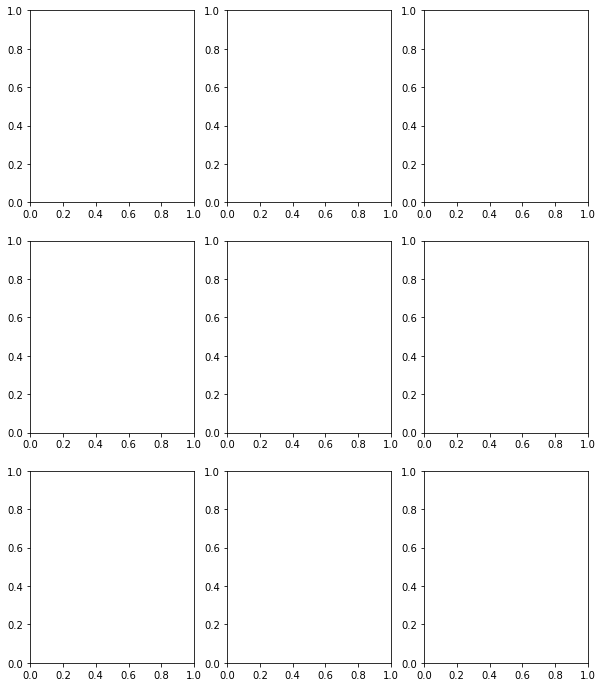

In [13]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

In [18]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [26]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

InvalidArgumentError: ignored

In [25]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

NameError: ignored

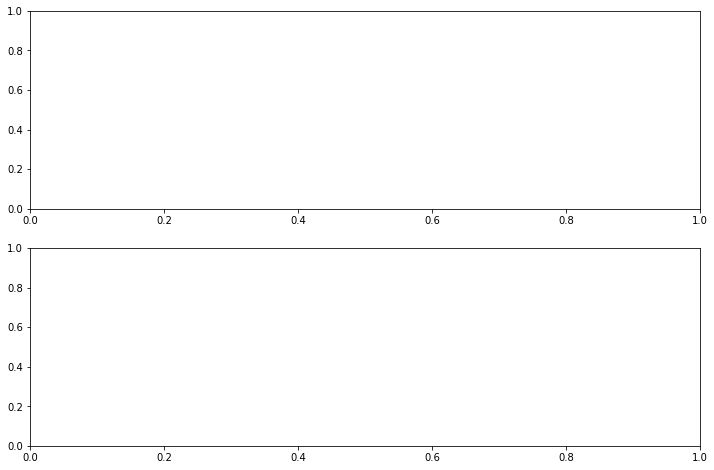

In [24]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()